# Regression example using TF-MELT
This is a basic regression example using the models in TF-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [2]:
# Use sklearn scaling libraries to normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_normalizer = StandardScaler()
y_normalizer = StandardScaler()

x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

# Hyperparameters
Set consistent hyperparameters for all models for comparisons sake.

In [3]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-3
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.0
input_dropout = 0.0
batch_norm = False
output_activation = "linear"

width = 8
depth = 2

# ResNet specific hyperparameters
layers_per_block = 4

## Artificial Neural Network (ANN)
Create and train an ANN using TF-MELT.

In [4]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
ann_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
)

# Compile the model
ann_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
ann_model.build(input_shape=(None, n_features))
ann_model.summary()


Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 output (Dense)              multiple                  27        
                                                                 
 bulk_0 (Dense)              multiple                  72        
                                                                 
 bulk_1 (Dense)              multiple                  72        
                                                                 
 bulk_act_0 (Activation)     multiple                  0         
                                         

In [5]:
# Train the model
history = ann_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.0031 - val_loss: 1.3203
Epoch 2/300
25/25 [==============================] - 0s 888us/step - loss: 0.9254 - val_loss: 1.2490
Epoch 3/300
25/25 [==============================] - 0s 953us/step - loss: 0.8731 - val_loss: 1.1703
Epoch 4/300
25/25 [==============================] - 0s 837us/step - loss: 0.8254 - val_loss: 1.0936
Epoch 5/300
25/25 [==============================] - 0s 693us/step - loss: 0.7759 - val_loss: 0.9940
Epoch 6/300
25/25 [==============================] - 0s 677us/step - loss: 0.7189 - val_loss: 0.8899
Epoch 7/300
25/25 [==============================] - 0s 693us/step - loss: 0.6496 - val_loss: 0.7694
Epoch 8/300
25/25 [==============================] - 0s 673us/step - loss: 0.5714 - val_loss: 0.6332
Epoch 9/300
25/25 [==============================] - 0s 672us/step - loss: 0.4851 - val_loss: 0.5093
Epoch 10/300
25/25 [==============================] - 0s 720us/step - loss: 0.3973 - val_loss

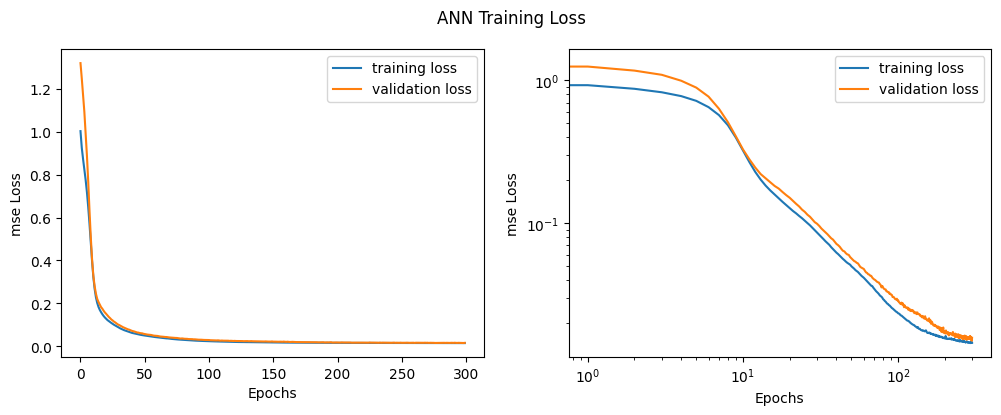

In [6]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history.history["loss"], label="training loss")
ax2.loglog(history.history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")

fig.suptitle("ANN Training Loss")
plt.show()

In [7]:
# Evaluate the model performance on train and validation data
pred_norm = ann_model(x_norm, training=False)
pred_norm_train = ann_model(x_train, training=False)
pred_norm_val = ann_model(x_val, training=False)
pred_norm_test = ann_model(x_test, training=False)

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm)
pred_train = y_normalizer.inverse_transform(pred_norm_train)
pred_val = y_normalizer.inverse_transform(pred_norm_val)
pred_test = y_normalizer.inverse_transform(pred_norm_test)

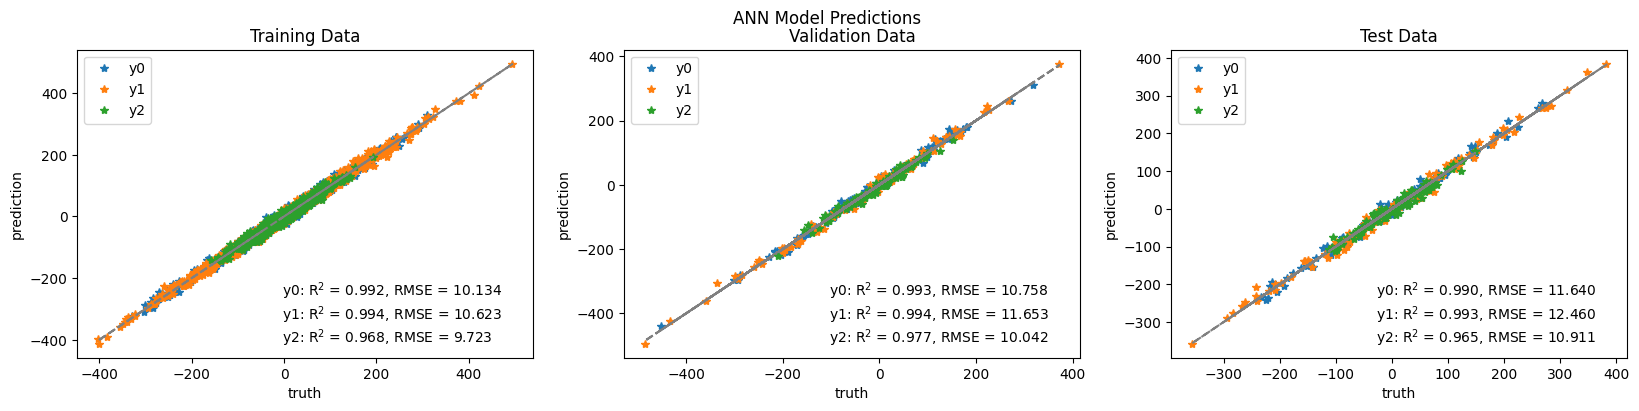

In [8]:
# Compute some statistics on the fit
import numpy as np

def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('ANN Model Predictions')
plt.show()

Let's do a quick test to see if we can compute the gradients of the model...

In [9]:
def numerical_jacobian(model, inputs, eps=1e-4):
    # Get the output shape by predicting on a single sample
    output_shape = model.predict(inputs[0:1]).shape[1]
    # Initialize a Jacobian matrix with zeros
    jacobian = np.zeros((output_shape, inputs.shape[1]))

    # Iterate over each input
    for i in range(inputs.shape[1]):
        # Create a copy of the inputs and perturb the i-th input
        pos_inputs = np.copy(inputs)
        pos_inputs[0, i] += eps
        neg_inputs = np.copy(inputs)
        neg_inputs[0, i] -= eps

        # Get the model's output for the perturbed inputs
        pos = model(pos_inputs)
        neg = model(neg_inputs)

        # Compute the numerical gradient for the i-th input
        num_grad = (pos - neg) / (2 * eps)

        # Update the Jacobian matrix
        jacobian[:, i] = num_grad.numpy().flatten()

    return jacobian

print(f"Shape of x_test: {x_train.shape}")
# Grab a set of inputs from the test data
x_sample = x_test[10, :].reshape(1, -1)
print(f"Shape of x_sample: {x_sample.shape}")

# Compute numerical gradients
num_jacobian = numerical_jacobian(ann_model, x_sample)

# Compute the tensorflow gradients
tfmelt_jacobian = ann_model.compute_jacobian(x_sample)

print("Numerical Jacobian Approximation:", num_jacobian)
print(f"Shape of numerical jacobian: {num_jacobian.shape}")
print("Tensorflow Jacobian Computation:", tfmelt_jacobian)
print(f"Shape of tfmelt jacobian: {tfmelt_jacobian.shape}")


Shape of x_test: (800, 10)
Shape of x_sample: (1, 10)
1/1 [==============================] - 0s 34ms/step
Numerical Jacobian Approximation: [[ 2.91466713e-01 -5.96046448e-04  6.34193420e-01  6.55651093e-02
  -1.19209290e-03 -5.96046448e-03  6.35385513e-01 -9.53674316e-03
   2.68220901e-01  1.31130219e-02]
 [ 5.20646572e-01 -1.19209290e-03  5.44190407e-01  4.57167625e-01
  -7.45058060e-03  7.74860382e-03  5.22136688e-01  2.08616257e-03
   8.10623169e-02 -1.49011612e-02]
 [ 5.56111336e-01  2.32458115e-02  4.20212746e-01  5.72204590e-02
  -1.78813934e-03 -8.94069672e-03  7.96318054e-01  5.96046448e-03
   1.16825104e-01  1.25169754e-02]]
Shape of numerical jacobian: (3, 10)
Tensorflow Jacobian Computation: tf.Tensor(
[[[[ 2.90886939e-01 -5.70617522e-06  6.34761930e-01  6.50351197e-02
    -8.37089261e-04 -5.59187680e-03  6.37331128e-01 -9.08321049e-03
     2.67547429e-01  1.24681024e-02]]

  [[ 5.20969927e-01 -7.70271639e-04  5.44631779e-01  4.57337230e-01
    -7.61908153e-03  8.14307295e-0

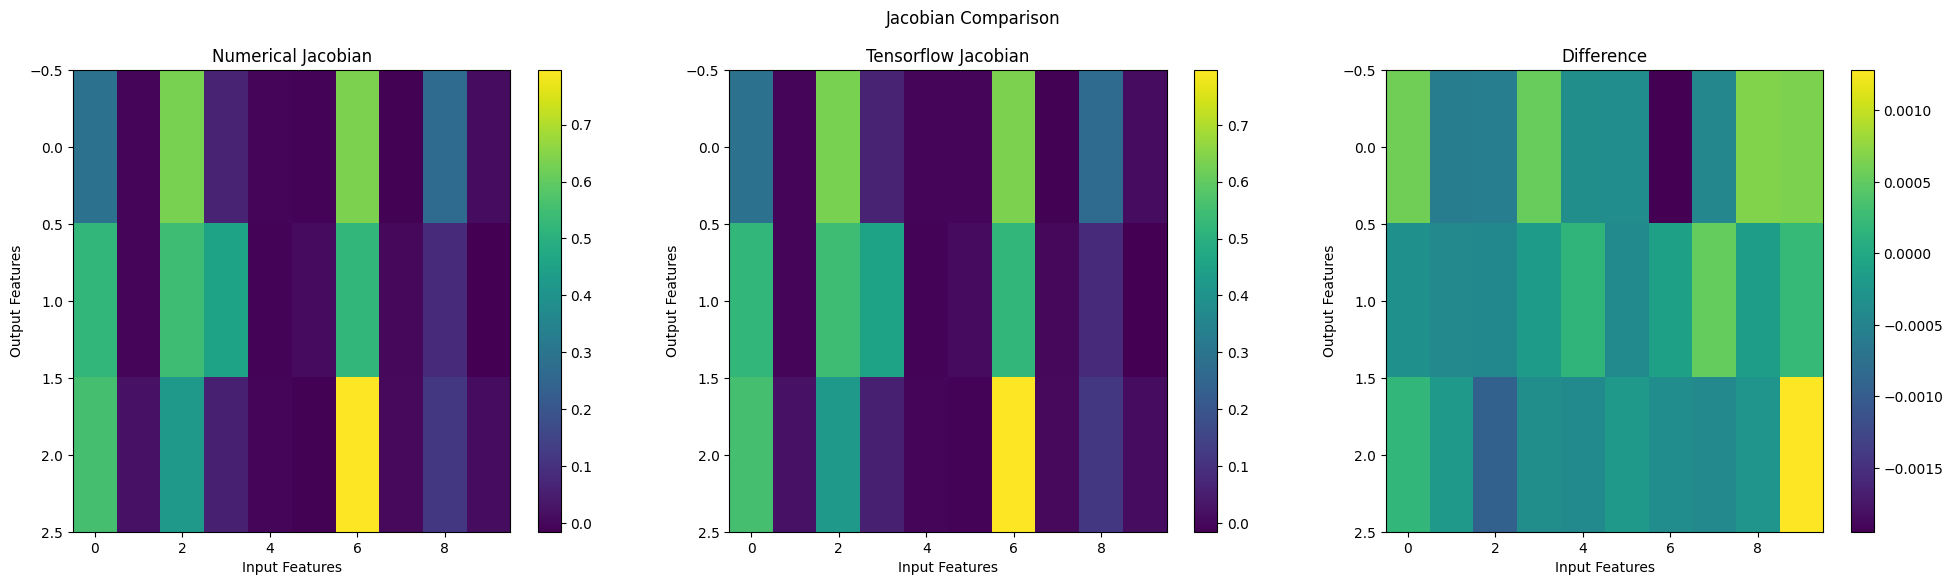

In [10]:
# Plot the numerical and tensorflow jacobians
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
cb1 = ax1.imshow(num_jacobian, aspect="auto")
ax1.set_title("Numerical Jacobian")
ax1.set_xlabel("Input Features")
ax1.set_ylabel("Output Features")
plt.colorbar(cb1)

cb2 = ax2.imshow(tfmelt_jacobian[0, :, 0, :], aspect="auto")
ax2.set_title("Tensorflow Jacobian")
ax2.set_xlabel("Input Features")
ax2.set_ylabel("Output Features")
plt.colorbar(cb2)

cb3 = ax3.imshow(num_jacobian - tfmelt_jacobian[0, :, 0, :], aspect="auto")
ax3.set_title("Difference")
ax3.set_xlabel("Input Features")
ax3.set_ylabel("Output Features")
plt.colorbar(cb3)

fig.suptitle("Jacobian Comparison")
plt.show()

## Residual Neural Network (ResNet)
Create and train a ResNet using TF-MELT.

In [11]:
from tfmelt.models import ResidualNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
resnet_model = ResidualNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    layers_per_block=layers_per_block,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    pre_activation=True,
    post_add_activation=False,
    output_activation=output_activation,
)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
resnet_model.build(input_shape=(None, n_features))
resnet_model.summary()


Model: "residual_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 output (Dense)              multiple                  27        
                                                                 
 bulk_0 (Dense)              multiple                  72        
                                                                 
 bulk_1 (Dense)              multiple                  72        
                                                                 
 bulk_act_0 (Activation)     multiple                  0         
                                           

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:281: UserWarning: Warning: depth (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(


In [12]:
# Train the model
history = resnet_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.7734 - val_loss: 1.7801
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 1.3112 - val_loss: 1.5020
Epoch 3/300
25/25 [==============================] - 0s 995us/step - loss: 1.0939 - val_loss: 1.3390
Epoch 4/300
25/25 [==============================] - 0s 880us/step - loss: 0.9724 - val_loss: 1.2121
Epoch 5/300
25/25 [==============================] - 0s 696us/step - loss: 0.8843 - val_loss: 1.1104
Epoch 6/300
25/25 [==============================] - 0s 684us/step - loss: 0.8122 - val_loss: 1.0192
Epoch 7/300
25/25 [==============================] - 0s 846us/step - loss: 0.7428 - val_loss: 0.9305
Epoch 8/300
25/25 [==============================] - 0s 851us/step - loss: 0.6770 - val_loss: 0.8386
Epoch 9/300
25/25 [==============================] - 0s 739us/step - loss: 0.6081 - val_loss: 0.7465
Epoch 10/300
25/25 [==============================] - 0s 681us/step - loss: 0.5307 - val_loss: 

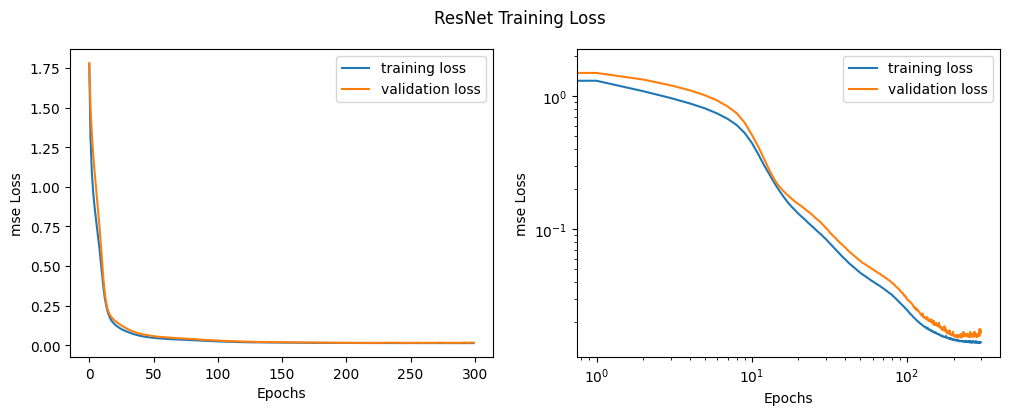

In [13]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history.history["loss"], label="training loss")
ax2.loglog(history.history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")

fig.suptitle("ResNet Training Loss")
plt.show()

In [14]:
# Evaluate the model performance on train and validation data
pred_norm = resnet_model(x_norm, training=False)
pred_norm_train = resnet_model(x_train, training=False)
pred_norm_val = resnet_model(x_val, training=False)
pred_norm_test = resnet_model(x_test, training=False)

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm)
pred_train = y_normalizer.inverse_transform(pred_norm_train)
pred_val = y_normalizer.inverse_transform(pred_norm_val)
pred_test = y_normalizer.inverse_transform(pred_norm_test)

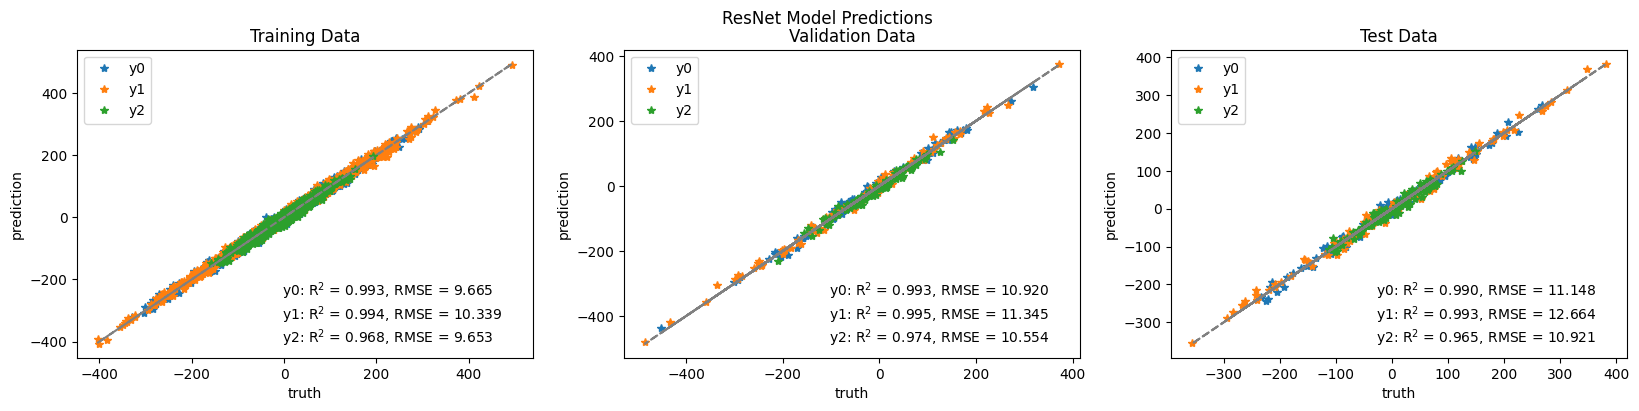

In [15]:
# Compute some statistics on the fit
import numpy as np

def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('ResNet Model Predictions')
plt.show()

## Bayesian Neural Network (BNN)
Create and train a BNN using TF-MELT. We can specify the number of bayesian layers desired to increase complexity.

#### Epistemic Uncertainty Predictions
We will turn off the aleatoric output layer and instead train an epistemic BNN model (of varying number of layers). Predictions will be made using Monte Carlo methods.

In [16]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
width = 8
depth = 3
num_bayesian_layers = 3
do_aleatoric = False

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    num_bayesian_layers=num_bayesian_layers,
    do_aleatoric=do_aleatoric,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()


Model: "bayesian_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 bayesian_0 (DenseFlipout)   multiple                  136       
                                                                 
 bayesian_1 (DenseFlipout)   multiple                  136       
                                                                 
 bayesian_2 (DenseFlipout)   multiple                  136       
                                                                 
 bulk_act_0 (Activation)     multiple                  0         
                                           

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [17]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 1s 9ms/step - loss: 1.6283 - val_loss: 2.0266
Epoch 2/300
25/25 [==============================] - 0s 2ms/step - loss: 1.6215 - val_loss: 2.0197
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 1.6145 - val_loss: 2.0112
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 1.6072 - val_loss: 2.0008
Epoch 5/300
25/25 [==============================] - 0s 913us/step - loss: 1.5981 - val_loss: 1.9880
Epoch 6/300
25/25 [==============================] - 0s 897us/step - loss: 1.5834 - val_loss: 1.9683
Epoch 7/300
25/25 [==============================] - 0s 868us/step - loss: 1.5469 - val_loss: 1.9119
Epoch 8/300
25/25 [==============================] - 0s 888us/step - loss: 1.4371 - val_loss: 1.7412
Epoch 9/300
25/25 [==============================] - 0s 870us/step - loss: 1.1995 - val_loss: 1.5084
Epoch 10/300
25/25 [==============================] - 0s 870us/step - loss: 1.0496 - val_loss: 1.24

In [18]:
# Evaluate the model performance using Monte Carlo ensemble predictions
import numpy as np

num_preds = 500
pred_norm_train = np.stack([bnn_model(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([bnn_model(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([bnn_model(x_test, training=False) for _ in range(num_preds)], axis=0)

# First, unscale the results of the ensemble before computing the statistics
pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

# Compute the mean and standard deviation of the predictions
pred_mean_train = np.mean(pred_train, axis=0)
pred_std_train = np.std(pred_train, axis=0)
pred_mean_val = np.mean(pred_val, axis=0)
pred_std_val = np.std(pred_val, axis=0)
pred_mean_test = np.mean(pred_test, axis=0)
pred_std_test = np.std(pred_test, axis=0)

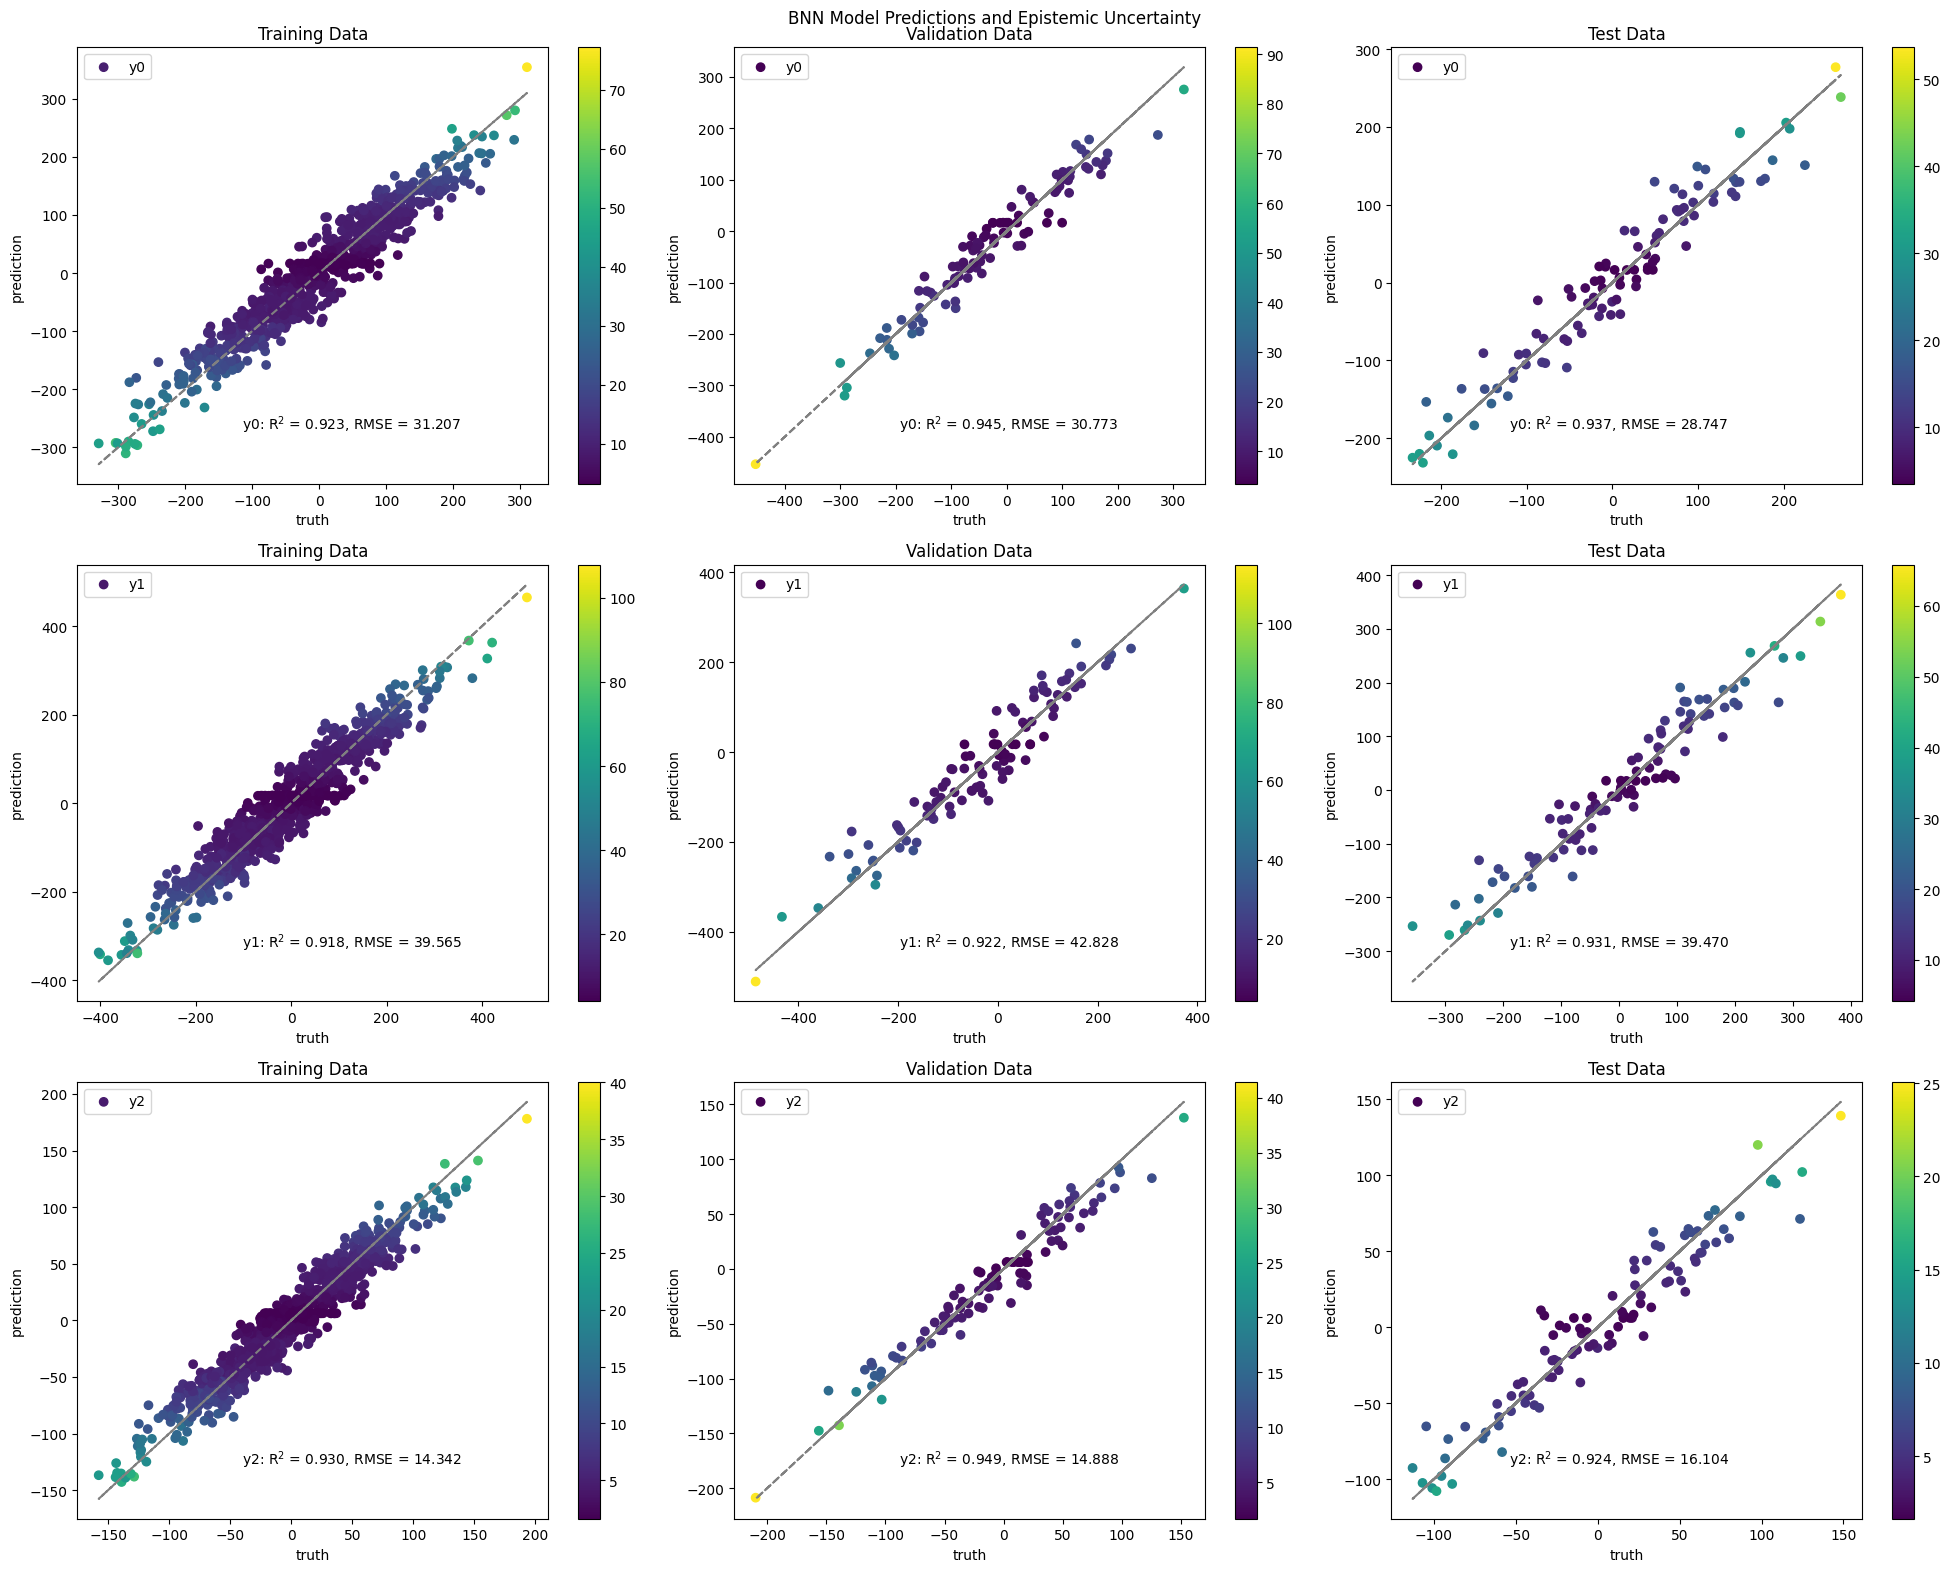

In [19]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('BNN Model Predictions and Epistemic Uncertainty')
fig.tight_layout()
plt.show()

Check to see if the jacobian computations also work with the Bayesian structure...

In [20]:

print(f"Shape of x_test: {x_train.shape}")
# Grab a set of inputs from the test data
x_sample = x_test[10, :].reshape(1, -1)
print(f"Shape of x_sample: {x_sample.shape}")

# Compute the tensorflow gradients
tfmelt_jacobian = bnn_model.compute_jacobian(x_sample)
# Compute the ann graients again
tfmelt_jac_ann = ann_model.compute_jacobian(x_sample)

print("Tensorflow Jacobian Computation:", tfmelt_jacobian)
print(f"Shape of tfmelt jacobian: {tfmelt_jacobian.shape}")

Shape of x_test: (800, 10)
Shape of x_sample: (1, 10)
Tensorflow Jacobian Computation: tf.Tensor(
[[[[ 0.22250073  0.00226449  0.25821087  0.10185678 -0.00206874
     0.00302024  0.31448507  0.0013039   0.08218253  0.00236619]]

  [[ 0.25855973  0.00263148  0.30005717  0.11836394 -0.002404
     0.0035097   0.36545128  0.00151521  0.09550123  0.00274966]]

  [[ 0.24081944  0.00245093  0.27946964  0.11024275 -0.00223906
     0.00326889  0.34037694  0.00141125  0.0889487   0.002561  ]]]], shape=(1, 3, 1, 10), dtype=float64)
Shape of tfmelt jacobian: (1, 3, 1, 10)


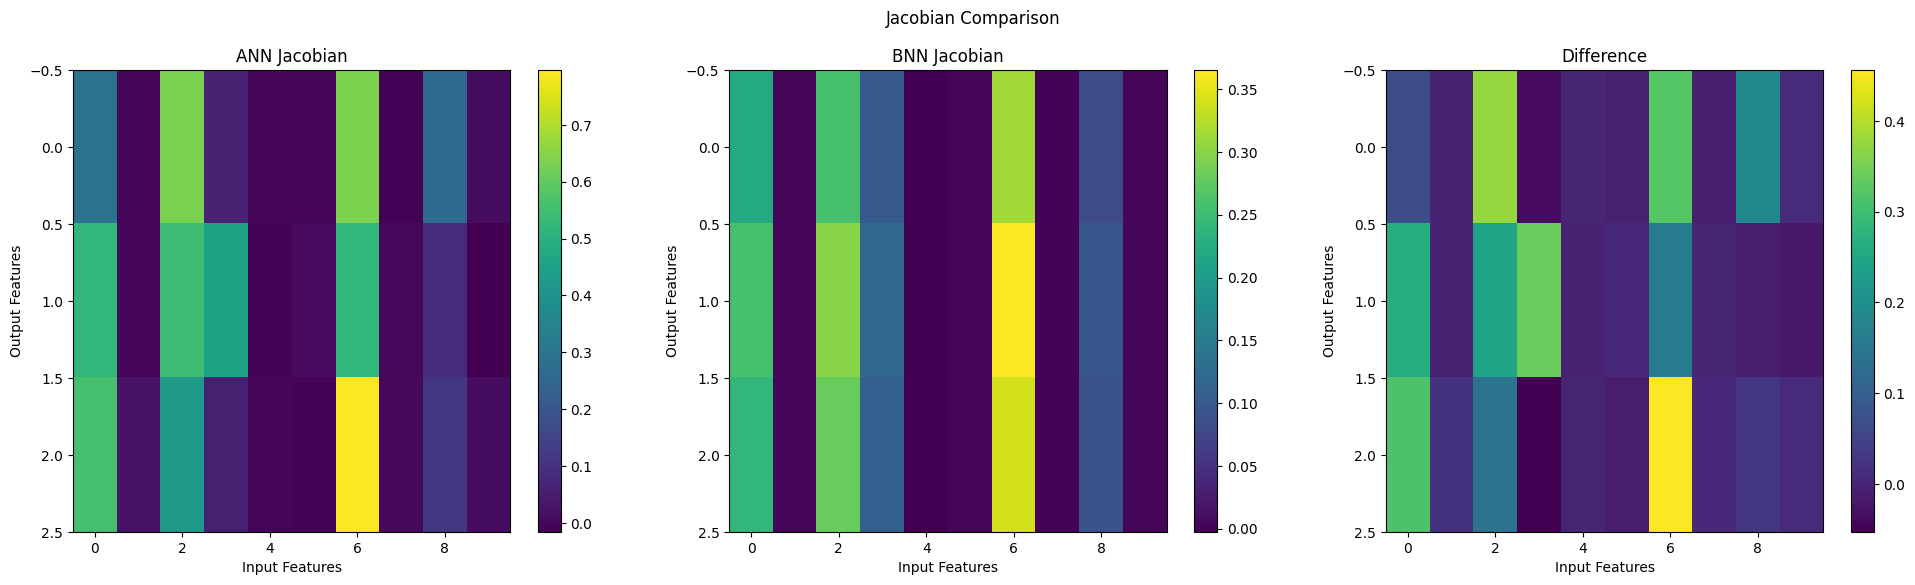

In [21]:
# plot comparison of ann and bnn jacobians
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
cb1 = ax1.imshow(tfmelt_jac_ann[0, :, 0, :], aspect="auto")
ax1.set_title("ANN Jacobian")
ax1.set_xlabel("Input Features")
ax1.set_ylabel("Output Features")
plt.colorbar(cb1)

cb2 = ax2.imshow(tfmelt_jacobian[0, :, 0, :], aspect="auto")
ax2.set_title("BNN Jacobian")
ax2.set_xlabel("Input Features")
ax2.set_ylabel("Output Features")
plt.colorbar(cb2)

cb3 = ax3.imshow(tfmelt_jac_ann[0, :, 0, :] - tfmelt_jacobian[0, :, 0, :], aspect="auto")
ax3.set_title("Difference")
ax3.set_xlabel("Input Features")
ax3.set_ylabel("Output Features")
plt.colorbar(cb3)

fig.suptitle("Jacobian Comparison")
plt.show()

#### Aleatoric Uncertainty Predictions
Now examine aleatoric uncertainty predictions as well as combined predictions if `num_bayesian_layers` is greater than 1.

In [22]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
width = 8
depth = 3
num_bayesian_layers = 3
do_aleatoric = True
batch_norm = True
use_batch_renorm = True
n_epochs = 200
l1_reg = 0
l2_reg = 0

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    num_bayesian_layers=num_bayesian_layers,
    do_aleatoric=do_aleatoric,
    use_batch_renorm=use_batch_renorm,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()

Model: "bayesian_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormali  multiple                  56        
 zation)                                                         
                                                                 
 batch_norm_1 (BatchNormali  multiple                  56        
 zation)                                                         
                                                                 
 batch_norm_2 (BatchNormali  multiple                  56        
 zation)                                                         
                                                                 
 batch_norm_3 (BatchNormali  multiple                  0 (unused)
 zation)                                                         
                                                                 
 input2bulk (Dense)          multiple    

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:554: UserWarning: Loss function is overridden when using aleatoric uncertainty. Using the negative log likelihood loss function.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [23]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/200
25/25 [==============================] - 1s 9ms/step - loss: 2.0822 - val_loss: 2.4807
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 2.0170 - val_loss: 2.3972
Epoch 3/200
25/25 [==============================] - 0s 1ms/step - loss: 1.9504 - val_loss: 2.2464
Epoch 4/200
25/25 [==============================] - 0s 1ms/step - loss: 1.8536 - val_loss: 1.9164
Epoch 5/200
25/25 [==============================] - 0s 970us/step - loss: 1.6634 - val_loss: 1.6367
Epoch 6/200
25/25 [==============================] - 0s 950us/step - loss: 1.4654 - val_loss: 1.4100
Epoch 7/200
25/25 [==============================] - 0s 957us/step - loss: 1.3464 - val_loss: 1.3587
Epoch 8/200
25/25 [==============================] - 0s 976us/step - loss: 1.3065 - val_loss: 1.2686
Epoch 9/200
25/25 [==============================] - 0s 975us/step - loss: 1.2843 - val_loss: 1.3027
Epoch 10/200
25/25 [==============================] - 0s 985us/step - loss: 1.2735 - val_loss: 1.24

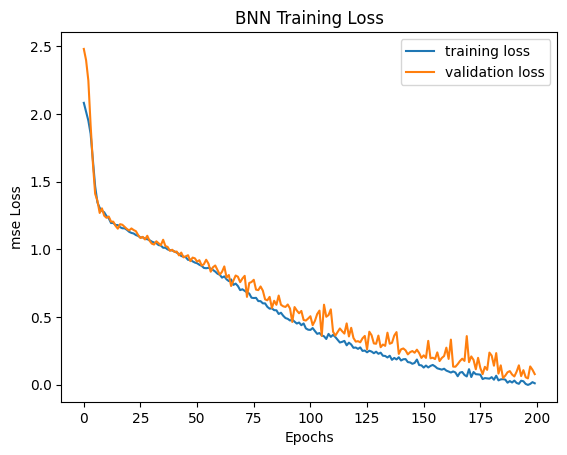

In [24]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel(f"{loss} Loss")
plt.title("BNN Training Loss")
plt.show()

In [25]:
# Evaluate the model performance with Monte Carlo ensemble predictions for Aleatoric and Epistemic Uncertainty
import numpy as np
import tensorflow_probability as tfp

num_preds = 100
pred_norm_train = np.stack([bnn_model(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([bnn_model(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([bnn_model(x_test, training=False) for _ in range(num_preds)], axis=0)

# If we are using aleatoric uncertainty, we have to unscale the distribution parameters
if do_aleatoric:
    pred_train = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_train])
    pred_val = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_val])
    pred_test = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_test])

    pred_mean_train = np.stack([y.mean().numpy() for y in pred_train]).mean(axis=0)
    pred_eu_train = np.stack([y.mean().numpy() for y in pred_train]).std(axis=0)
    pred_au_train = np.stack([y.stddev().numpy() for y in pred_train]).mean(axis=0)

    pred_mean_val = np.stack([y.mean().numpy() for y in pred_val]).mean(axis=0)
    pred_eu_val = np.stack([y.mean().numpy() for y in pred_val]).std(axis=0)
    pred_au_val = np.stack([y.stddev().numpy() for y in pred_val]).mean(axis=0)

    pred_mean_test = np.stack([y.mean().numpy() for y in pred_test]).mean(axis=0)
    pred_eu_test = np.stack([y.mean().numpy() for y in pred_test]).std(axis=0)
    pred_au_test = np.stack([y.stddev().numpy() for y in pred_test]).mean(axis=0)
    
# If we are not using aleatoric uncertainty, we can unscale the predictions directly
else:
    pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
    pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
    pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

    # Compute the mean and standard deviation of the predictions
    pred_mean_train = np.mean(pred_train, axis=0)
    pred_eu_train = np.std(pred_train, axis=0)
    pred_au_train = np.zeros(pred_mean_train.shape)

    pred_mean_val = np.mean(pred_val, axis=0)
    pred_eu_val = np.std(pred_val, axis=0)
    pred_au_val = np.zeros(pred_mean_val.shape)

    pred_mean_test = np.mean(pred_test, axis=0)
    pred_eu_test = np.std(pred_test, axis=0)
    pred_au_test = np.zeros(pred_mean_test.shape)



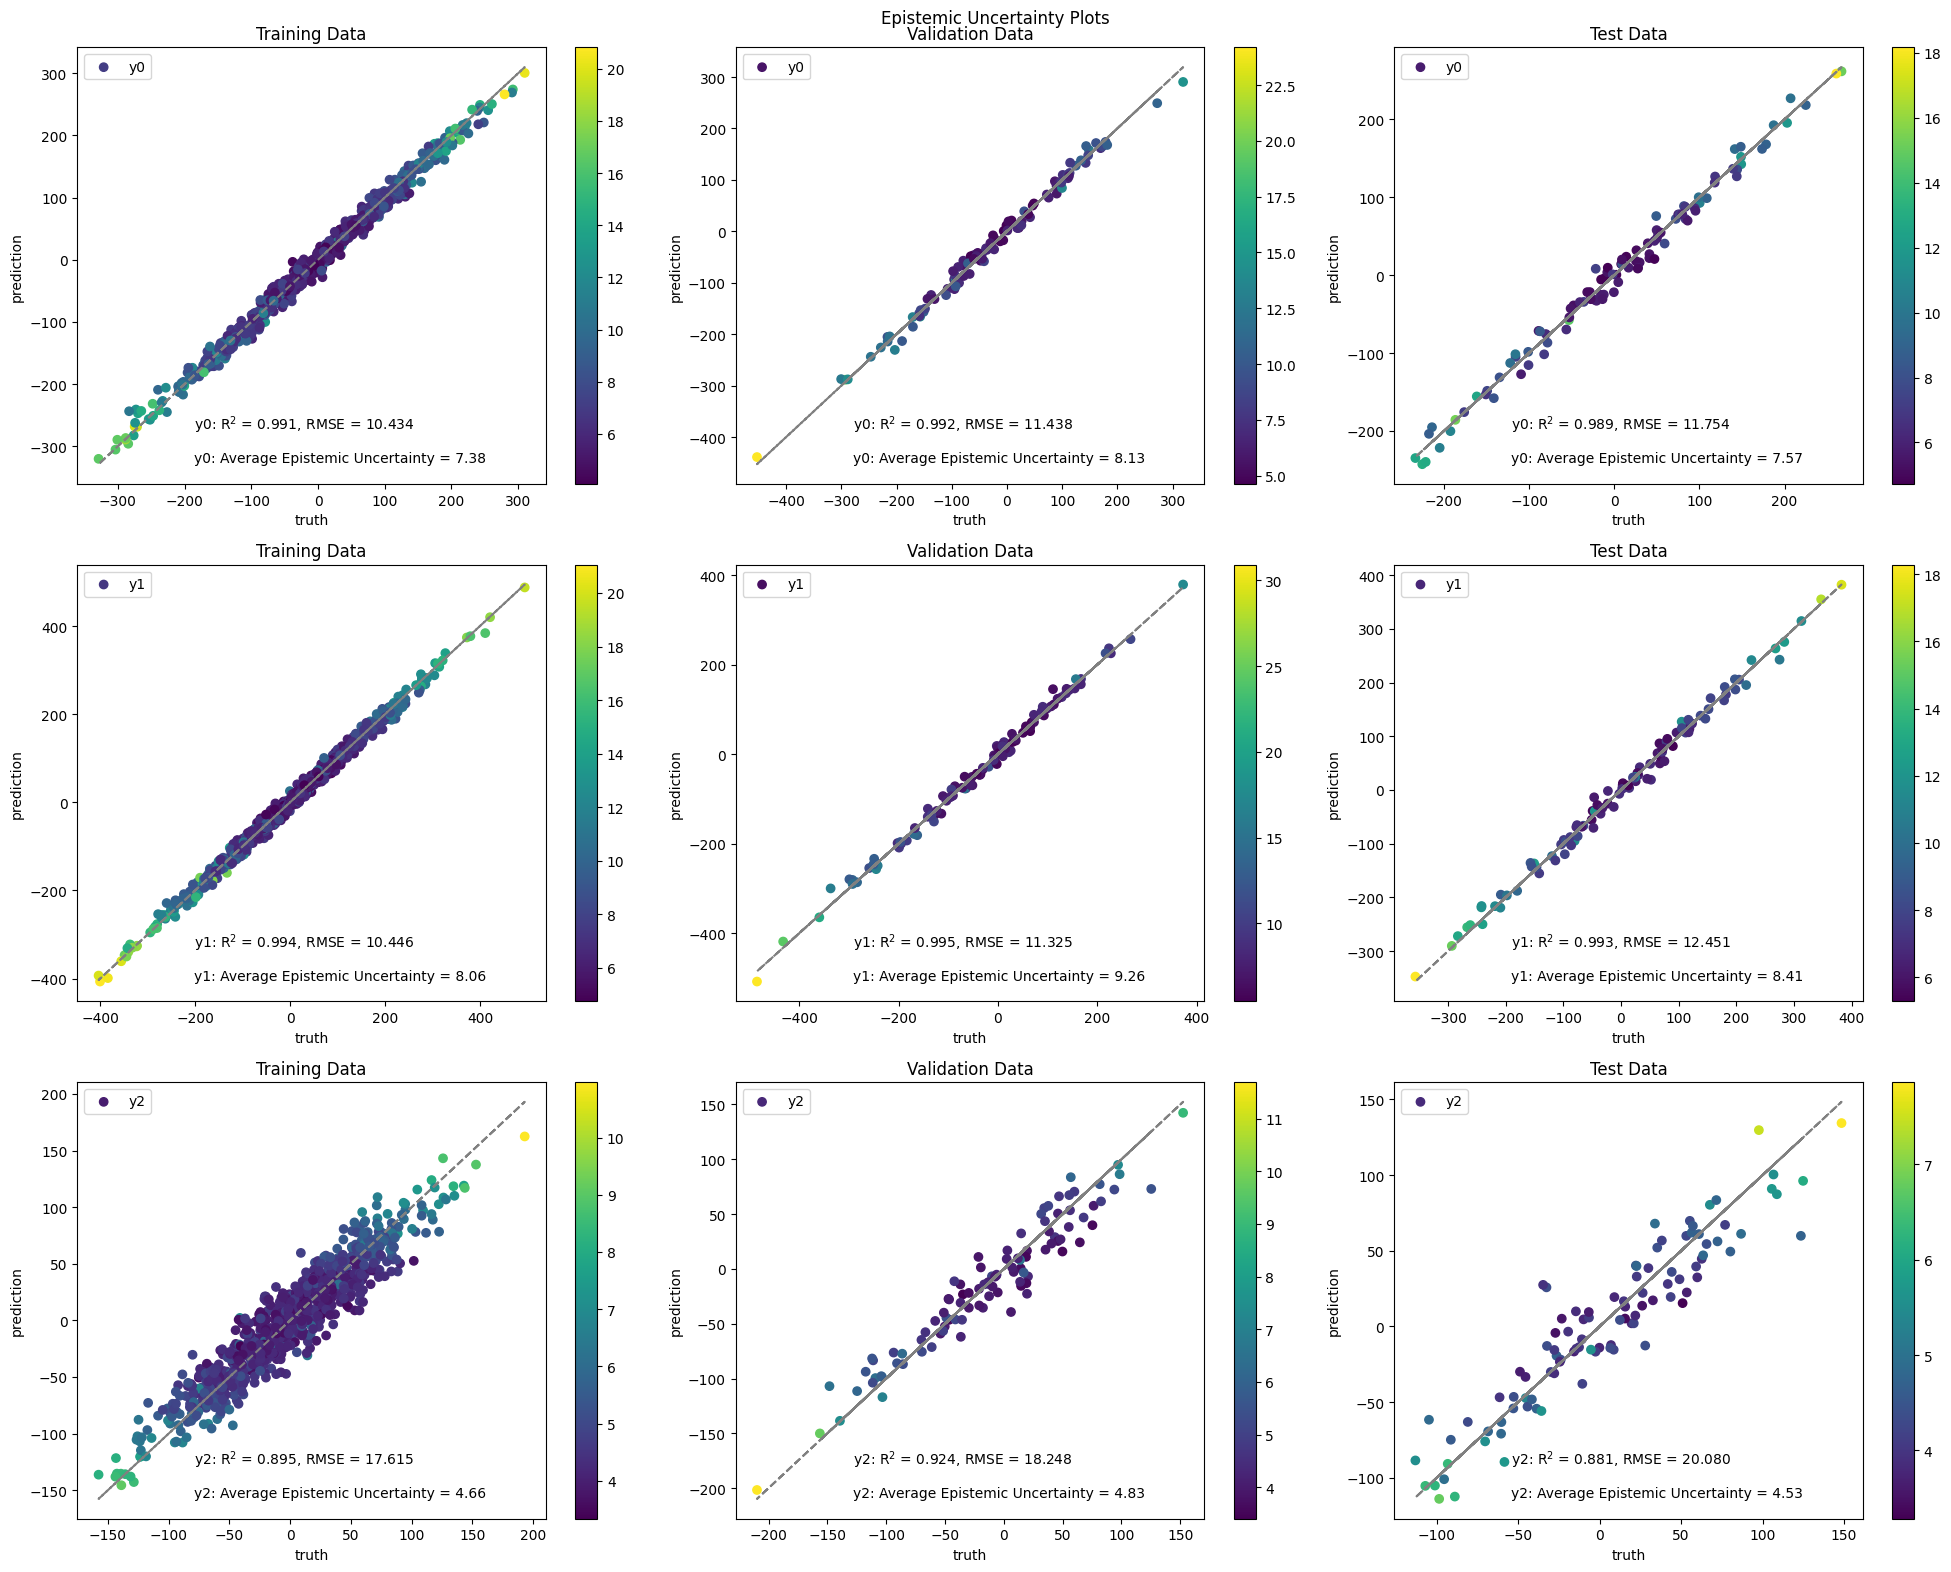

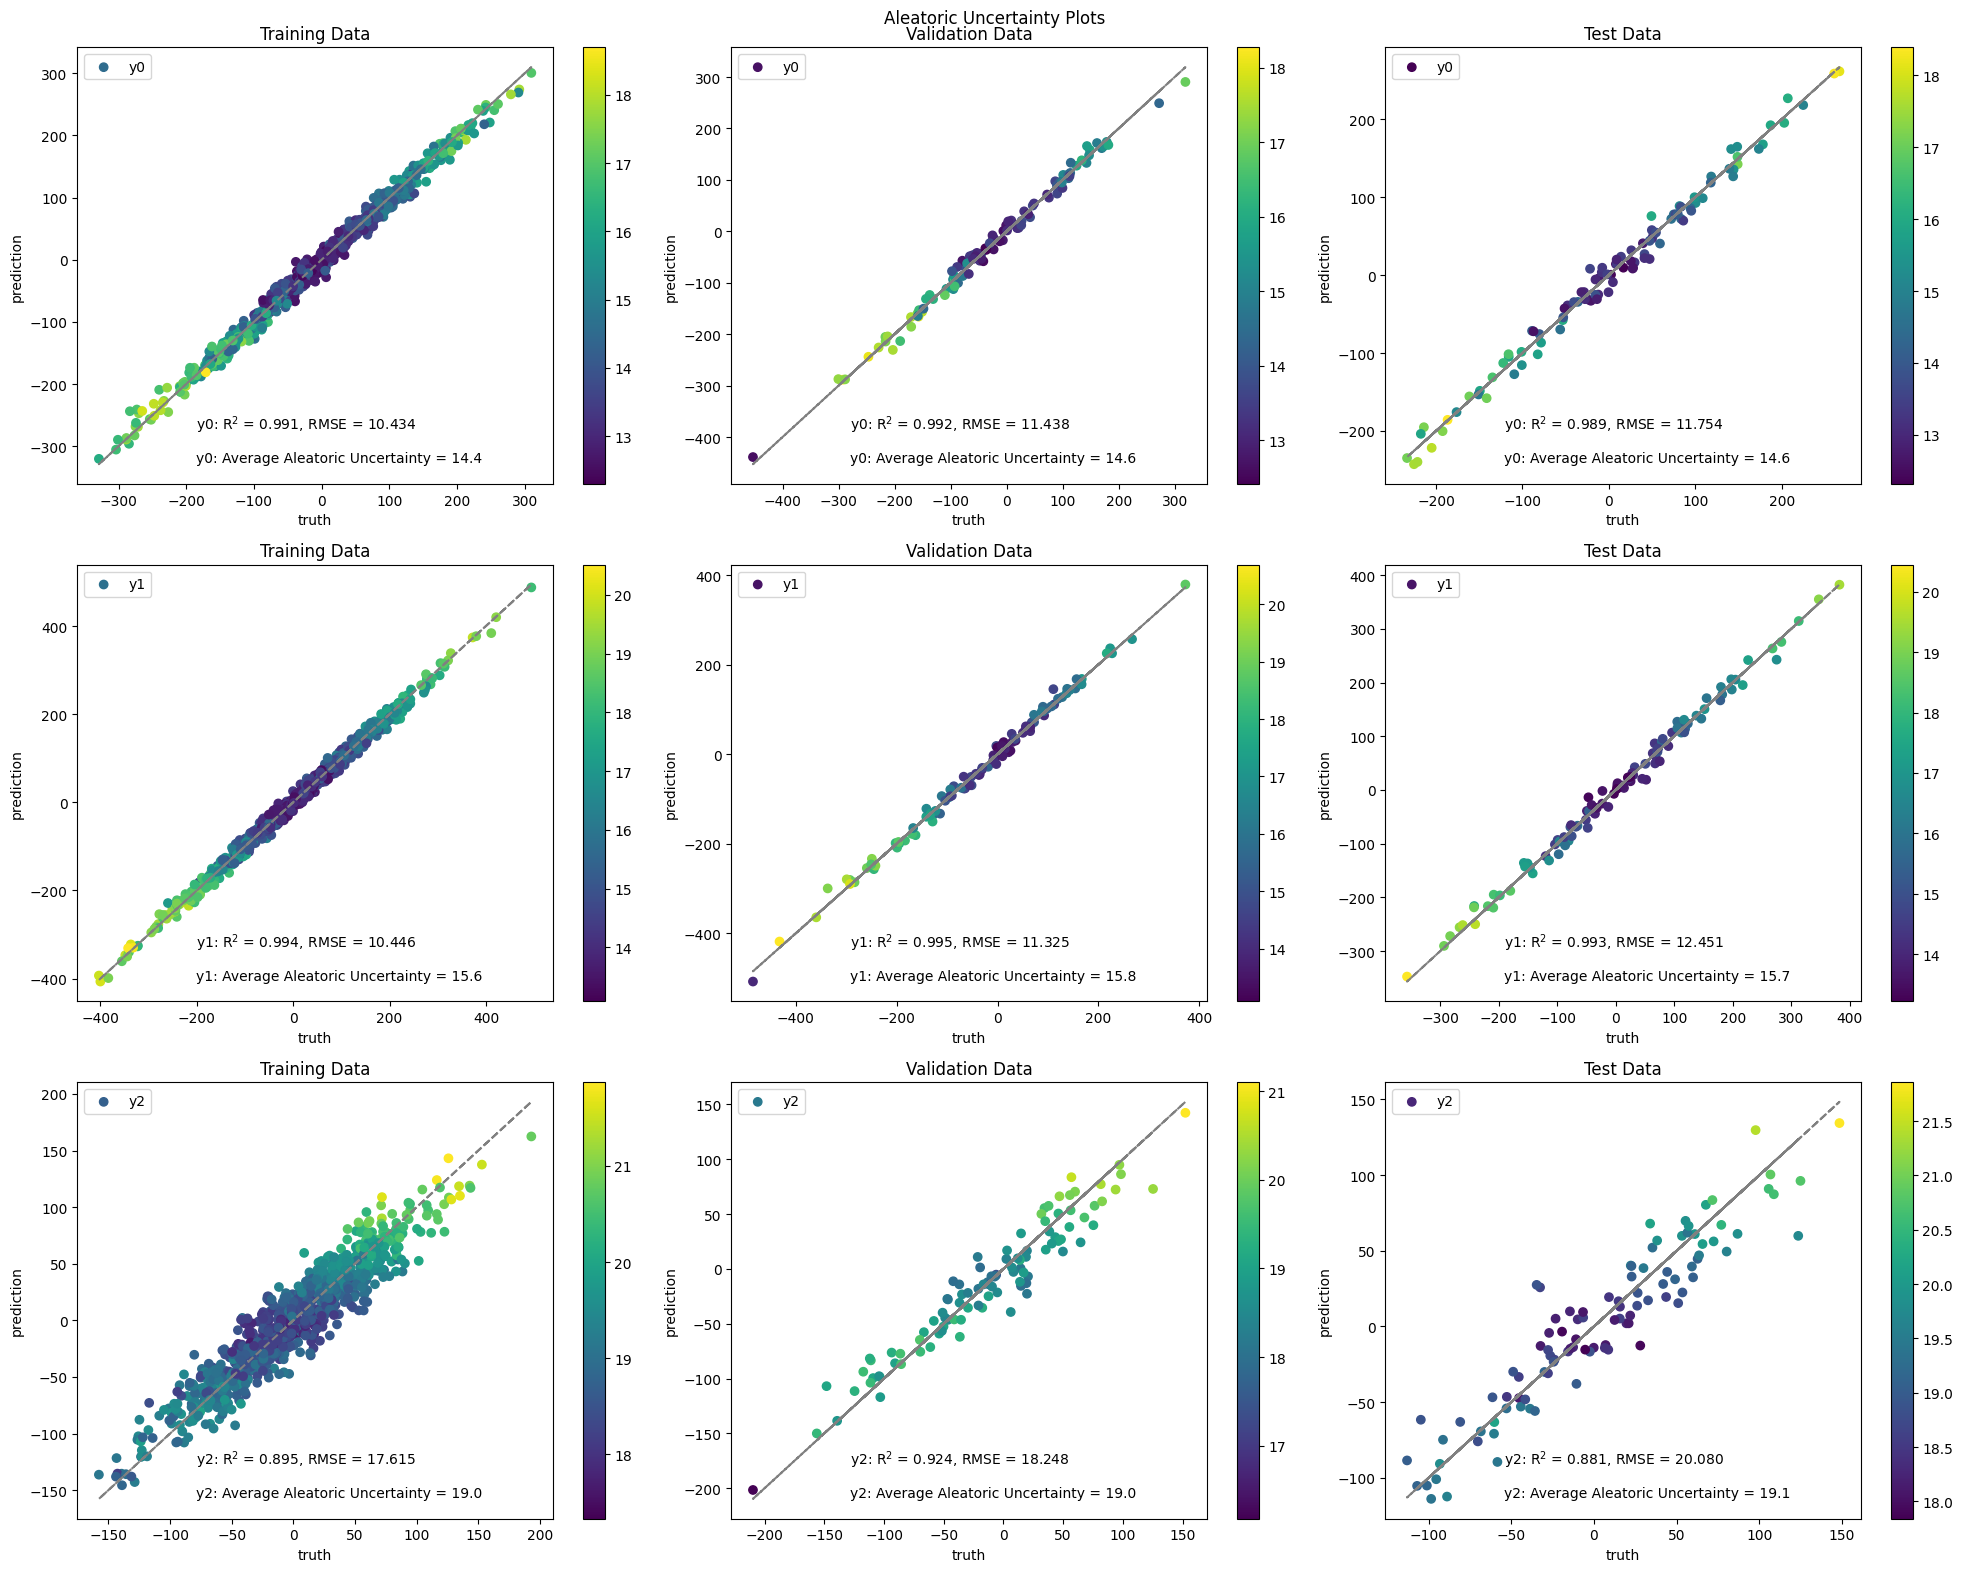

In [26]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)


# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Epistemic Uncertainty Plots')
fig.tight_layout()
plt.show()

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Aleatoric Uncertainty Plots')
fig.tight_layout()
plt.show()